# Bilateral International Migration prediction using Deep Learning #
### Model variant: adding lagged Migration as additional feature ###


Ludwig-Maximilians-Universität M.Economics Machine Learning Applications - WS2020/21 Term Paper

Code by: Yunting LIU,  15.03.2021

## Note ##

For an introduction to the research topic and methodology see accompanying document "Notes to exam project_bilateral migration prediction". This notebook is an extension to the base notebook "Exam_bilateral_migration_predictions_deep_learning"

# Initialising

In [1]:
import os
import wget
from pathlib import Path

import pandas as pd
import numpy as np
import xarray
#import pandas_profiling

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Metric

import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score 
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


import xgboost as xgb
from typing import Tuple
from xgboost import XGBRegressor

import shap
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999



/Users/jacqueline/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jacqueline/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Set a random seed to ensure result reproducibility
import random as python_random
random_seed = 123
np.random.seed(random_seed)
python_random.seed(random_seed)
tf.random.set_seed(random_seed)



In [3]:
# Change current working directory for convenience

os.chdir('/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper


# Data

The main data set is made available from [2] and downloaded on the following website : [https://www.sciencedirect.com/science/article/pii/S0304387819304900](https://www.sciencedirect.com/science/article/pii/S0304387819304900)

For convenience i have downloaded a copy of this in my local directory.

## Data import 

In [4]:
os.getcwd()

'/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper'

In [5]:
data_in = pd.read_stata('./data/replication_bilateral.dta')

In [6]:
# skip data columns with "GTI" - these relate to internet search keywords which I wish to exclude for this first modelling
# further skip all the log transformation columns
exclude_log_cols = ['o_log_pop', 'd_log_pop', 'o_log_gdp', 'd_log_gdp', 'log_mig_stock']
cols = [c for c in data_in.columns if (c.lower()[:3] != 'gti' and c.lower() not in exclude_log_cols)]

data=data_in[cols].copy()

data

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


In [7]:
data.shape

(23947, 29)

In [8]:
data.dtypes

pair_id                  int32
iso3n_o                  int32
iso3n_d                  int32
year                     int32
source_country          object
iso3_o                  object
iso3_d                  object
log_mig                float32
fwd_log_mig            float32
o_sl_uem_totl_zs       float32
o_sp_pop_0014_to_zs    float32
sfi_sfi                float64
pol4_autoc             float64
o_IT_CEL_SETS_P2       float64
o_IT_NET_USER_P2       float64
o_number_weather          int8
o_number_nonweather       int8
mig_stock_tot          float32
o_French               float64
o_Spanish              float64
o_English              float64
d_GDP                  float32
d_pop                  float32
o_GDP                  float32
o_pop                  float32
tot_mig                float32
fwd_tot_mig            float32
iso3n_oXyear             int32
iso3n_dXyear             int32
dtype: object

## Data Exploration 

In [9]:
# take a look into a random subset of data
# pandas_profiling.ProfileReport(data.sample(n = 5000, random_state = 123))

# Model Training 

## Data preparation for modelling, split and feature selection 

In [10]:
data_modelling = data

# use log(migration) as model target; this forces models to always predict a positive value for migration
target = 'fwd_log_mig' 

unused_feat = ['Set', 'iso3n_o', 'iso3n_d', 'source_country', 'iso3n_oXyear', 'iso3n_dXyear', 'tot_mig', 'fwd_tot_mig']

features = [ col for col in data_modelling.columns if col not in unused_feat+[target]] 
col_used = [ col for col in data_modelling.columns if col not in unused_feat] 

In [11]:
data_modelling

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


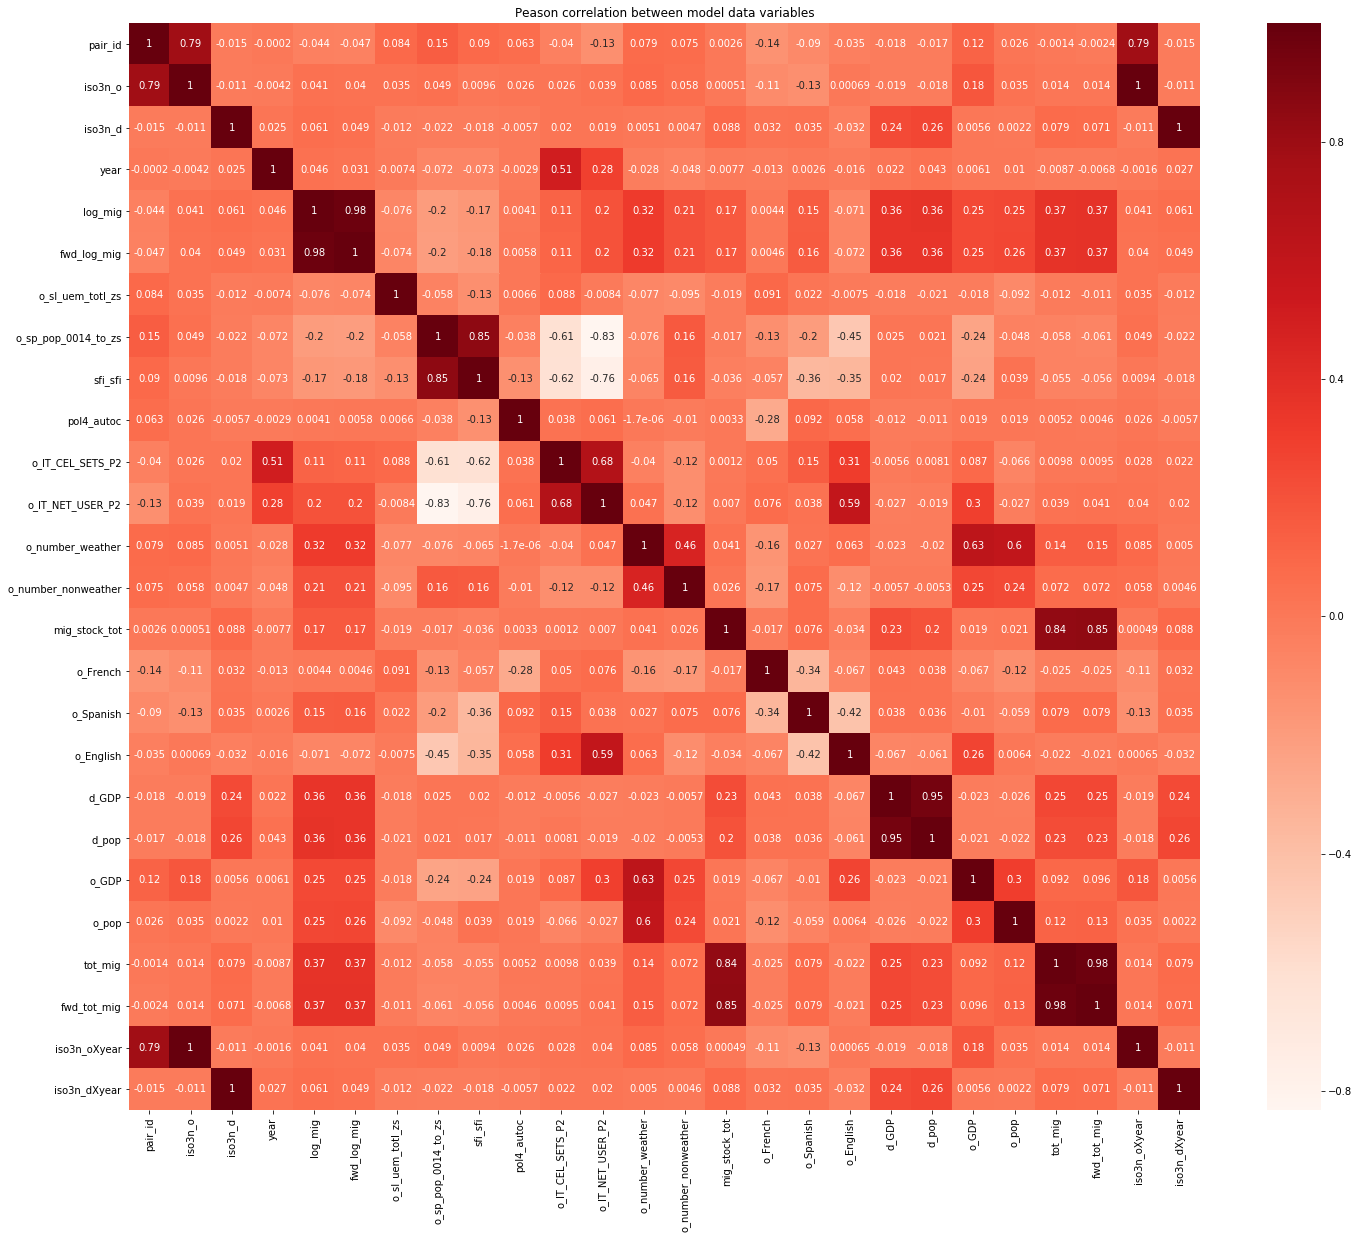

In [14]:
# Check correlation on modelling data (using Pearson Correlation)
cor = data_modelling.corr()

plt.figure(figsize=(24,20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    
plt.title('Peason correlation between model data variables', fontsize=12)

plt.savefig('./exhibits/variant_lag/corr_model_data.png')

In [15]:
data_modelling = data_modelling[col_used].copy()

# convert pair_id to string
data_modelling['pair_id']= data_modelling['pair_id'].apply(str)

# in keeping with original paper, use 2004-2012 data as train set, 2013 as validation set, and 2014 as test set
if "Set" not in data_modelling.columns:
    data_modelling['Set'] = data_modelling.apply(lambda x: 'test' if x.year == 2014 else 'valid' if x.year ==2013 else 'train', axis = 1)
#    data_modelling["Set"] = np.random.choice(["train", "valid", "test"], p =[.6, .2, .2], size=(data_modelling.shape[0],))

train_indices = data_modelling[data_modelling.Set=="train"].index
valid_indices = data_modelling[data_modelling.Set=="valid"].index
test_indices = data_modelling[data_modelling.Set=="test"].index

In [16]:
data_modelling

,pair_id,year,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,Set
0,171,2004,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,train
1,171,2005,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,train
2,171,2006,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,train
3,171,2007,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,train
4,171,2008,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,2010,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,train
23943,7021,2011,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,train
23944,7021,2012,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,train
23945,7021,2013,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,valid


In [17]:
# Simple feature pre-processing

nunique = data_modelling.nunique()
types = data_modelling.dtypes

categorical_columns = []
categorical_dims =  {}

for col in data_modelling.columns[data_modelling.dtypes == object]:
    print(col, data_modelling[col].nunique())
    l_enc = LabelEncoder()
    data_modelling[col] = data_modelling[col].fillna("VV_likely")
    data_modelling[col] = l_enc.fit_transform(data_modelling[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

numerical_columns = []
numerical_dims =  {}    
    
for col in data_modelling.columns[data_modelling.dtypes == 'float64']:
    data_modelling.fillna(data_modelling.loc[train_indices, col].mean(), inplace=True)
#    sc = StandardScaler()
#    train[col] = sc.fit_transform(train[col].values)
#    train[col] = np.squeeze(sc.fit_transform(train[col].values.reshape(-1, 1)))
#    numerical_columns.append(col)
#    numerical_dims[col] = len(l_enc.classes_)
    

pair_id 2627
iso3_o 101
iso3_d 35
Set 3


In [18]:
categorical_columns

['pair_id', 'iso3_o', 'iso3_d', 'Set']

In [19]:
categorical_dims

{'pair_id': 2627, 'iso3_o': 101, 'iso3_d': 35, 'Set': 3}

In [20]:
data_modelling

,pair_id,year,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,Set
0,375,2004,0,0,5.950643,5.961005,12.600000,26.647324,4.0,0.0,35.272288,16.036684,3,0,9.678758,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,1
1,375,2005,0,0,5.961005,5.590987,10.600000,26.321699,2.0,0.0,57.328994,17.720583,1,0,9.678758,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,1
2,375,2006,0,0,5.590987,5.164786,10.100000,26.007032,2.0,0.0,80.818826,20.927202,1,0,9.678758,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,1
3,375,2007,0,0,5.164786,5.170484,8.500000,25.702198,2.0,0.0,102.721528,25.946633,3,0,9.678758,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,1
4,375,2008,0,0,5.170484,5.087596,7.800000,25.410353,2.0,0.0,117.221183,28.112623,1,1,9.678758,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,2514,2010,100,32,3.178054,3.433987,5.500000,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.000000,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,1
23943,2514,2011,100,32,3.433987,3.295837,5.400000,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.000000,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,1
23944,2514,2012,100,32,3.295837,2.772589,5.300000,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.000000,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,1
23945,2514,2013,100,32,2.772589,3.688879,5.400000,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.000000,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,2


In [21]:
# Split into train, validation and test set
X_train = data_modelling[features].values[train_indices]
y_train = data_modelling[target].values[train_indices].reshape(-1, 1)

X_valid = data_modelling[features].values[valid_indices]
y_valid = data_modelling[target].values[valid_indices].reshape(-1, 1)

X_test = data_modelling[features].values[test_indices]
y_test = data_modelling[target].values[test_indices].reshape(-1, 1)

In [22]:
# data_modelling.to_csv('./data/data_modelling.csv', sep=";")

## Defining CPC and R2 as custom metric, defining CPC as loss function 

In [23]:
# Define Common Part of Commuters (CPC) and R_squared as custom metrics

class CPC(Metric):
    def __init__(self):
        self._name = "cpc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        cpc = 2 * np.sum(np.minimum(y_true, y_score)) / (np.sum(y_true) + np.sum(y_score))
        return cpc

# Coefficient of determination r^2

class r_squared(Metric):
    def __init__(self):
        self._name = "r_squared"
        self._maximize = True

    def __call__(self, y_true, y_score):
        SS_res = np.sum(np.square(y_true - y_score))
        SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
        r_squared = (1 - SS_res / (SS_tot))          
        return r_squared

custom_metrics = ['mae', 'mse', 'rmse', r_squared, CPC]

In [24]:
# Again for Keras models
# Common Part of Commuters
def cpc_keras(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

# Coefficient of determination r^2
def r_squared_keras(y_true, y_pred):
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    r_squared = (1 - SS_res / (SS_tot + kb.epsilon()))
    return r_squared

rmse_keras = keras.metrics.RootMeanSquaredError()

custom_metrics_keras = ['mae', 'mse', rmse_keras, r_squared_keras, cpc_keras] # to be passed to model.compile(), metrics parameter


In [25]:
def cpc_loss(y_pred, y_true):
    cpc = 2 * torch.sum(torch.minimum(y_true, y_pred)) / (torch.sum(y_true) + torch.sum(y_pred))
    return 1-cpc

In [26]:
def cpc_loss_xgb(y_pred, y_true):
    print(y_pred)
    print(y_pred.shape)
    print(y_true)
    print(y_true.shape)
    cpc = 2 * sum(np.minimum(y_true, y_pred)) / (sum(y_true) + sum(y_pred))    
    return cpc

In [27]:
def cpc_loss_keras(y_true, y_pred):
#    return 1.0 - cpc_keras(y_true, y_pred)
    return 1.0 - (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

## Training Models - 1. TabNet Model 

In [28]:
# Define categorical features for categorical embeddings
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [29]:
cat_dims

[2627, 101, 35]

In [30]:
modelTabnet = TabNetRegressor(n_d=8, n_a=8, n_steps=5, cat_dims=cat_dims, cat_idxs=cat_idxs, seed=random_seed, optimizer_params=dict(lr=2e-3), clip_value=2., device_name='cpu')

modelTabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'valid'],
    eval_metric= ['mae', 'mse', 'rmse', r_squared, CPC],
    loss_fn = cpc_loss,
    max_epochs=1000,
    patience=50,
    batch_size=4096, 
    virtual_batch_size=1024,
    num_workers=0,
    drop_last=False,
) 

Device used : cpu
epoch 0  | loss: 0.47995 | train_mae: 397.002685546875| train_mse: 477499.03125| train_rmse: 691.0130615234375| train_r_squared: -71501.85938| train_cpc: 0.01489 | valid_mae: 397.0575866699219| valid_mse: 482282.78125| valid_rmse: 694.4658203125| valid_r_squared: -71599.35156| valid_cpc: 0.01537 |  0:00:01s
epoch 1  | loss: 0.44719 | train_mae: 359.9383544921875| train_mse: 344314.09375| train_rmse: 586.7828369140625| train_r_squared: -51558.14453| train_cpc: 0.01619 | valid_mae: 372.467041015625| valid_mse: 361635.375| valid_rmse: 601.3612670898438| valid_r_squared: -53687.87109| valid_cpc: 0.01623 |  0:00:03s
epoch 2  | loss: 0.42048 | train_mae: 412.2068786621094| train_mse: 503572.28125| train_rmse: 709.6282958984375| train_r_squared: -75406.17969| train_cpc: 0.0133  | valid_mae: 382.7994384765625| valid_mse: 460864.4375| valid_rmse: 678.8699951171875| valid_r_squared: -68419.55469| valid_cpc: 0.01475 |  0:00:04s
epoch 3  | loss: 0.38558 | train_mae: 397.922088623

epoch 27 | loss: 0.16306 | train_mae: 1.6634000539779663| train_mse: 12.91250991821289| train_rmse: 3.593400001525879| train_r_squared: -0.93358| train_cpc: 0.7471  | valid_mae: 1.6129200458526611| valid_mse: 11.59611988067627| valid_rmse: 3.4053099155426025| valid_r_squared: -0.72158| valid_cpc: 0.7578  |  0:00:41s
epoch 28 | loss: 0.15554 | train_mae: 1.704319953918457| train_mse: 12.944990158081055| train_rmse: 3.5979199409484863| train_r_squared: -0.93844| train_cpc: 0.73733 | valid_mae: 1.6606199741363525| valid_mse: 12.14268970489502| valid_rmse: 3.484639883041382| valid_r_squared: -0.80272| valid_cpc: 0.74808 |  0:00:42s
epoch 29 | loss: 0.15342 | train_mae: 1.57955002784729| train_mse: 10.12483024597168| train_rmse: 3.181950092315674| train_r_squared: -0.51614| train_cpc: 0.7593  | valid_mae: 1.5732799768447876| valid_mse: 9.74409008026123| valid_rmse: 3.1215500831604004| valid_r_squared: -0.44662| valid_cpc: 0.76691 |  0:00:44s
epoch 30 | loss: 0.14982 | train_mae: 1.575430035

epoch 53 | loss: 0.11324 | train_mae: 1.7217400074005127| train_mse: 6.362939834594727| train_rmse: 2.5224900245666504| train_r_squared: 0.04719 | train_cpc: 0.66407 | valid_mae: 1.7741199731826782| valid_mse: 6.163879871368408| valid_rmse: 2.482719898223877| valid_r_squared: 0.0849  | valid_cpc: 0.66156 |  0:01:24s
epoch 54 | loss: 0.11131 | train_mae: 1.9128199815750122| train_mse: 7.066889762878418| train_rmse: 2.658360004425049| train_r_squared: -0.05823| train_cpc: 0.60997 | valid_mae: 2.0025899410247803| valid_mse: 7.347139835357666| valid_rmse: 2.7105600833892822| valid_r_squared: -0.09077| valid_cpc: 0.59642 |  0:01:25s
epoch 55 | loss: 0.10886 | train_mae: 1.9668400287628174| train_mse: 7.036109924316406| train_rmse: 2.6525700092315674| train_r_squared: -0.05362| train_cpc: 0.5934  | valid_mae: 2.0776100158691406| valid_mse: 7.494420051574707| valid_rmse: 2.7375900745391846| valid_r_squared: -0.11263| valid_cpc: 0.57227 |  0:01:27s
epoch 56 | loss: 0.1079  | train_mae: 1.94084

epoch 79 | loss: 0.0974  | train_mae: 0.9432299733161926| train_mse: 2.1259799003601074| train_rmse: 1.4580800533294678| train_r_squared: 0.68165 | train_cpc: 0.83872 | valid_mae: 0.8777300119400024| valid_mse: 2.0151898860931396| valid_rmse: 1.4195799827575684| valid_r_squared: 0.70082 | valid_cpc: 0.8566  |  0:02:06s
epoch 80 | loss: 0.09761 | train_mae: 0.9145799875259399| train_mse: 2.1078898906707764| train_rmse: 1.451859951019287| train_r_squared: 0.68436 | train_cpc: 0.84612 | valid_mae: 0.8364499807357788| valid_mse: 1.8781800270080566| valid_rmse: 1.3704700469970703| valid_r_squared: 0.72116 | valid_cpc: 0.86506 |  0:02:08s
epoch 81 | loss: 0.09634 | train_mae: 0.8871200084686279| train_mse: 1.9299299716949463| train_rmse: 1.3892199993133545| train_r_squared: 0.711   | train_cpc: 0.84992 | valid_mae: 0.837369978427887| valid_mse: 1.854740023612976| valid_rmse: 1.3618899583816528| valid_r_squared: 0.72464 | valid_cpc: 0.8641  |  0:02:09s
epoch 82 | loss: 0.09677 | train_mae: 0.

epoch 105| loss: 0.09164 | train_mae: 0.5852599740028381| train_mse: 1.437459945678711| train_rmse: 1.1989400386810303| train_r_squared: 0.78475 | train_cpc: 0.90725 | valid_mae: 0.5894899964332581| valid_mse: 1.4540400505065918| valid_rmse: 1.205839991569519| valid_r_squared: 0.78413 | valid_cpc: 0.91004 |  0:02:49s
epoch 106| loss: 0.09327 | train_mae: 0.604449987411499| train_mse: 1.46110999584198| train_rmse: 1.2087600231170654| train_r_squared: 0.78121 | train_cpc: 0.90356 | valid_mae: 0.6039800047874451| valid_mse: 1.458109974861145| valid_rmse: 1.2075200080871582| valid_r_squared: 0.78353 | valid_cpc: 0.90705 |  0:02:51s
epoch 107| loss: 0.09243 | train_mae: 0.5997899770736694| train_mse: 1.4321199655532837| train_rmse: 1.1967099905014038| train_r_squared: 0.78555 | train_cpc: 0.90592 | valid_mae: 0.6195099949836731| valid_mse: 1.497290015220642| valid_rmse: 1.223639965057373| valid_r_squared: 0.77771 | valid_cpc: 0.90657 |  0:02:53s
epoch 108| loss: 0.09249 | train_mae: 0.59527

epoch 131| loss: 0.08379 | train_mae: 0.5115299820899963| train_mse: 0.8581699728965759| train_rmse: 0.9263700246810913| train_r_squared: 0.87149 | train_cpc: 0.91761 | valid_mae: 0.5230699777603149| valid_mse: 1.0138599872589111| valid_rmse: 1.0068999528884888| valid_r_squared: 0.84948 | valid_cpc: 0.91874 |  0:03:33s
epoch 132| loss: 0.0837  | train_mae: 0.5091400146484375| train_mse: 0.8602200150489807| train_rmse: 0.9274799823760986| train_r_squared: 0.87119 | train_cpc: 0.91846 | valid_mae: 0.5239400267601013| valid_mse: 1.0173300504684448| valid_rmse: 1.0086300373077393| valid_r_squared: 0.84897 | valid_cpc: 0.91911 |  0:03:35s
epoch 133| loss: 0.08492 | train_mae: 0.5108799934387207| train_mse: 0.8672800064086914| train_rmse: 0.9312800168991089| train_r_squared: 0.87013 | train_cpc: 0.91842 | valid_mae: 0.5299000144004822| valid_mse: 1.0365400314331055| valid_rmse: 1.0181000232696533| valid_r_squared: 0.84611 | valid_cpc: 0.91849 |  0:03:37s
epoch 134| loss: 0.0837  | train_mae:

epoch 157| loss: 0.08269 | train_mae: 0.49915000796318054| train_mse: 0.8503699898719788| train_rmse: 0.9221500158309937| train_r_squared: 0.87266 | train_cpc: 0.92021 | valid_mae: 0.516480028629303| valid_mse: 1.0110900402069092| valid_rmse: 1.0055299997329712| valid_r_squared: 0.84989 | valid_cpc: 0.92066 |  0:04:19s
epoch 158| loss: 0.0836  | train_mae: 0.5024999976158142| train_mse: 0.8926799893379211| train_rmse: 0.944819986820221| train_r_squared: 0.86633 | train_cpc: 0.91915 | valid_mae: 0.5067200064659119| valid_mse: 1.0149199962615967| valid_rmse: 1.0074299573898315| valid_r_squared: 0.84932 | valid_cpc: 0.92166 |  0:04:20s
epoch 159| loss: 0.08123 | train_mae: 0.4909200072288513| train_mse: 0.8324699997901917| train_rmse: 0.9124000072479248| train_r_squared: 0.87534 | train_cpc: 0.92114 | valid_mae: 0.4991599917411804| valid_mse: 0.9792799949645996| valid_rmse: 0.9895899891853333| valid_r_squared: 0.85461 | valid_cpc: 0.92281 |  0:04:22s
epoch 160| loss: 0.08122 | train_mae: 

epoch 183| loss: 0.08023 | train_mae: 0.48443999886512756| train_mse: 0.8029000163078308| train_rmse: 0.896049976348877| train_r_squared: 0.87977 | train_cpc: 0.92256 | valid_mae: 0.4888100028038025| valid_mse: 0.9337599873542786| valid_rmse: 0.9663100242614746| valid_r_squared: 0.86137 | valid_cpc: 0.92482 |  0:05:04s
epoch 184| loss: 0.08097 | train_mae: 0.48555999994277954| train_mse: 0.8334900140762329| train_rmse: 0.9129599928855896| train_r_squared: 0.87519 | train_cpc: 0.92206 | valid_mae: 0.48684000968933105| valid_mse: 0.9428099989891052| valid_rmse: 0.9709799885749817| valid_r_squared: 0.86003 | valid_cpc: 0.92488 |  0:05:05s
epoch 185| loss: 0.07876 | train_mae: 0.4838300049304962| train_mse: 0.8203799724578857| train_rmse: 0.9057499766349792| train_r_squared: 0.87715 | train_cpc: 0.92245 | valid_mae: 0.48840001225471497| valid_mse: 0.9440500140190125| valid_rmse: 0.9716200232505798| valid_r_squared: 0.85985 | valid_cpc: 0.92477 |  0:05:07s
epoch 186| loss: 0.07934 | train_m

epoch 209| loss: 0.0784  | train_mae: 0.46917998790740967| train_mse: 0.7363799810409546| train_rmse: 0.8581200242042542| train_r_squared: 0.88973 | train_cpc: 0.92496 | valid_mae: 0.482369989156723| valid_mse: 0.8972300291061401| valid_rmse: 0.9472200274467468| valid_r_squared: 0.8668  | valid_cpc: 0.92568 |  0:05:50s
epoch 210| loss: 0.07779 | train_mae: 0.4624600112438202| train_mse: 0.7187600135803223| train_rmse: 0.8478000164031982| train_r_squared: 0.89237 | train_cpc: 0.92591 | valid_mae: 0.4724299907684326| valid_mse: 0.8806099891662598| valid_rmse: 0.9384099841117859| valid_r_squared: 0.86926 | valid_cpc: 0.92705 |  0:05:52s
epoch 211| loss: 0.07863 | train_mae: 0.4690600037574768| train_mse: 0.7351300120353699| train_rmse: 0.8574000000953674| train_r_squared: 0.88992 | train_cpc: 0.92436 | valid_mae: 0.4774799942970276| valid_mse: 0.9006800055503845| valid_rmse: 0.9490399956703186| valid_r_squared: 0.86628 | valid_cpc: 0.92579 |  0:05:53s
epoch 212| loss: 0.078   | train_mae:

epoch 235| loss: 0.07698 | train_mae: 0.468860000371933| train_mse: 0.7197200059890747| train_rmse: 0.848360002040863| train_r_squared: 0.89223 | train_cpc: 0.92523 | valid_mae: 0.4720500111579895| valid_mse: 0.8453999757766724| valid_rmse: 0.9194499850273132| valid_r_squared: 0.87449 | valid_cpc: 0.9274  |  0:06:36s
epoch 236| loss: 0.07748 | train_mae: 0.4671199917793274| train_mse: 0.718999981880188| train_rmse: 0.8479400277137756| train_r_squared: 0.89233 | train_cpc: 0.92547 | valid_mae: 0.47040000557899475| valid_mse: 0.8463900089263916| valid_rmse: 0.9200000166893005| valid_r_squared: 0.87434 | valid_cpc: 0.92763 |  0:06:38s
epoch 237| loss: 0.07667 | train_mae: 0.4600200057029724| train_mse: 0.69309002161026| train_rmse: 0.8325200080871582| train_r_squared: 0.89621 | train_cpc: 0.92619 | valid_mae: 0.4619799852371216| valid_mse: 0.8205900192260742| valid_rmse: 0.9058600068092346| valid_r_squared: 0.87817 | valid_cpc: 0.92847 |  0:06:40s
epoch 238| loss: 0.07615 | train_mae: 0.4

epoch 261| loss: 0.07455 | train_mae: 0.45399999618530273| train_mse: 0.6783300042152405| train_rmse: 0.8236100077629089| train_r_squared: 0.89842 | train_cpc: 0.92729 | valid_mae: 0.4666700065135956| valid_mse: 0.853600025177002| valid_rmse: 0.9239000082015991| valid_r_squared: 0.87327 | valid_cpc: 0.92789 |  0:07:23s
epoch 262| loss: 0.07567 | train_mae: 0.45405998826026917| train_mse: 0.6767399907112122| train_rmse: 0.8226400017738342| train_r_squared: 0.89866 | train_cpc: 0.92734 | valid_mae: 0.46540001034736633| valid_mse: 0.8456599712371826| valid_rmse: 0.9196000099182129| valid_r_squared: 0.87445 | valid_cpc: 0.92811 |  0:07:25s
epoch 263| loss: 0.07518 | train_mae: 0.46149998903274536| train_mse: 0.6936900019645691| train_rmse: 0.8328800201416016| train_r_squared: 0.89612 | train_cpc: 0.92613 | valid_mae: 0.4722299873828888| valid_mse: 0.8846399784088135| valid_rmse: 0.9405500292778015| valid_r_squared: 0.86866 | valid_cpc: 0.92705 |  0:07:27s
epoch 264| loss: 0.07518 | train_m

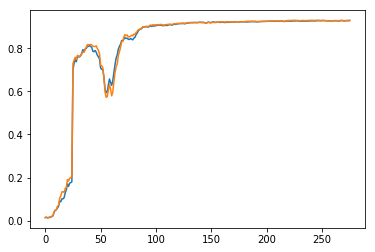

In [31]:
# plot losses
# plt.plot(modelTabnet.history['loss'])

# Plot development of cpc

plt.plot(modelTabnet.history['train_cpc'])
plt.plot(modelTabnet.history['valid_cpc'])

## Training Models - 2. Artificial Neural Network (ANN)  

In [34]:
# define ANN model
# @l : loss function to build model
# @size_hidden_layer : the size of all the hidden layers of the ANN 
# @dropout : the dropout of the model
# @n_layer : the number of hidden layers of the model
# @returns : the defined model
def defineANN(n_features = 21,l=cpc_loss_keras,size_hidden_layer=20,dropout=0.15,n_layer=2):  #l=cpc_loss_keras
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout,input_shape=(n_features,)))
    for i in range(n_layer):
        model.add(Dense(size_hidden_layer, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.002, clipnorm = 2)
    model.compile(optimizer=opt, loss=l, metrics = custom_metrics_keras)
#  model.compile(optimizer='adam'(lr=0.001), loss=l, metrics = custom_metrics_keras)

    return model

In [35]:
modelAnn = defineANN()
#es = EarlyStopping(monitor='val_cpc_keras', mode='max', verbose=1, patience=200)
historyAnn = modelAnn.fit(X_train, y_train, epochs=1000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid))
#historyAnn = modelAnn.fit(X_train, y_train, epochs=2000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid), callbacks=[es])


Epoch 1/1000
78/78 [==============================] - 1s 4ms/step - loss: -5.7458 - mae: 1902.8371 - mse: 1031429416.0506 - root_mean_squared_error: 30012.7687 - r_squared_keras: -150837924.6266 - cpc_keras: 6.7451 - val_loss: 0.9963 - val_mae: 2419.8481 - val_mse: 1265459840.0000 - val_root_mean_squared_error: 35573.3008 - val_r_squared_keras: -180917264.0000 - val_cpc_keras: 0.0041
Epoch 2/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.9968 - mae: 2842.1225 - mse: 2028568530.8354 - root_mean_squared_error: 43574.7123 - r_squared_keras: -309948099.2911 - cpc_keras: 0.0032 - val_loss: 0.9957 - val_mae: 2051.7954 - val_mse: 849645056.0000 - val_root_mean_squared_error: 29148.6719 - val_r_squared_keras: -121469864.0000 - val_cpc_keras: 0.0048
Epoch 3/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.9963 - mae: 2544.2207 - mse: 1624749035.7468 - root_mean_squared_error: 38264.8578 - r_squared_keras: -1294651114.7342 - cpc_keras: 0.0037 - val_loss: 0

78/78 [==============================] - 0s 1ms/step - loss: -0.0188 - mae: 18.2814 - mse: 96578.0950 - root_mean_squared_error: 301.3740 - r_squared_keras: -14477.3147 - cpc_keras: 1.0191 - val_loss: 0.7381 - val_mae: 23.0848 - val_mse: 95784.4453 - val_root_mean_squared_error: 309.4906 - val_r_squared_keras: -13688.2549 - val_cpc_keras: 0.2885
Epoch 24/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.8034 - mae: 10.3007 - mse: 12482.7747 - root_mean_squared_error: 100.7854 - r_squared_keras: -1676.3064 - cpc_keras: 0.1967 - val_loss: -0.4887 - val_mae: 14.3799 - val_mse: 53086.7031 - val_root_mean_squared_error: 230.4055 - val_r_squared_keras: -7585.2139 - val_cpc_keras: 1.4198
Epoch 25/1000
78/78 [==============================] - 0s 1ms/step - loss: 1.3336 - mae: 13.8205 - mse: 38530.8766 - root_mean_squared_error: 178.5966 - r_squared_keras: -5719.6735 - cpc_keras: -0.3333 - val_loss: 0.7045 - val_mae: 22.4643 - val_mse: 182282.3594 - val_root_mean_squared_error

Epoch 46/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.6262 - mae: 10.8406 - mse: 25887.3013 - root_mean_squared_error: 153.5045 - r_squared_keras: -3587.6639 - cpc_keras: 0.3739 - val_loss: 0.4426 - val_mae: 6.0543 - val_mse: 7587.0044 - val_root_mean_squared_error: 87.1034 - val_r_squared_keras: -1084.1705 - val_cpc_keras: 0.5695
Epoch 47/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.8034 - mae: 8.7710 - mse: 20556.0523 - root_mean_squared_error: 140.4965 - r_squared_keras: -2939.3397 - cpc_keras: 0.1967 - val_loss: 0.6312 - val_mae: 16.3030 - val_mse: 82341.1641 - val_root_mean_squared_error: 286.9515 - val_r_squared_keras: -11771.8262 - val_cpc_keras: 0.3951
Epoch 48/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.7688 - mae: 14.2057 - mse: 77183.0372 - root_mean_squared_error: 272.5247 - r_squared_keras: -11660.4550 - cpc_keras: 0.2313 - val_loss: 0.7092 - val_mae: 21.7635 - val_mse: 120167.9688 - val_root_mean_square

Epoch 69/1000
78/78 [==============================] - 0s 1ms/step - loss: 1.0821 - mae: 6.1333 - mse: 7743.7506 - root_mean_squared_error: 81.2719 - r_squared_keras: -1153.2328 - cpc_keras: -0.0818 - val_loss: 0.4675 - val_mae: 7.0113 - val_mse: 10245.0986 - val_root_mean_squared_error: 101.2181 - val_r_squared_keras: -1463.9594 - val_cpc_keras: 0.5523
Epoch 70/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.4755 - mae: 4.7934 - mse: 3890.0071 - root_mean_squared_error: 57.2064 - r_squared_keras: -555.7465 - cpc_keras: 0.5245 - val_loss: 0.3473 - val_mae: 3.6583 - val_mse: 1962.2015 - val_root_mean_squared_error: 44.2967 - val_r_squared_keras: -279.6344 - val_cpc_keras: 0.6731
Epoch 71/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.8668 - mae: 3.9621 - mse: 1959.8749 - root_mean_squared_error: 40.5663 - r_squared_keras: -265.0039 - cpc_keras: 0.1333 - val_loss: 0.4183 - val_mae: 5.3592 - val_mse: 4440.6982 - val_root_mean_squared_error: 66.6386

78/78 [==============================] - 0s 1ms/step - loss: 1.3484 - mae: 4.7760 - mse: 1260.8453 - root_mean_squared_error: 35.2935 - r_squared_keras: -181.3108 - cpc_keras: -0.3482 - val_loss: 0.5019 - val_mae: 5.1555 - val_mse: 8476.6055 - val_root_mean_squared_error: 92.0685 - val_r_squared_keras: -1211.4257 - val_cpc_keras: 0.5317
Epoch 93/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.6532 - mae: 6.0492 - mse: 14263.5885 - root_mean_squared_error: 111.2620 - r_squared_keras: -2072.3427 - cpc_keras: 0.3469 - val_loss: 0.5651 - val_mae: 11.1482 - val_mse: 30690.4961 - val_root_mean_squared_error: 175.1870 - val_r_squared_keras: -4385.2676 - val_cpc_keras: 0.4603
Epoch 94/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.3068 - mae: 4.3141 - mse: 2141.4835 - root_mean_squared_error: 45.3174 - r_squared_keras: -295.4189 - cpc_keras: 0.6938 - val_loss: 0.4663 - val_mae: 6.6868 - val_mse: 7749.9009 - val_root_mean_squared_error: 88.0335 - val_r_s

78/78 [==============================] - 0s 1ms/step - loss: 0.0675 - mae: 2.6001 - mse: 796.1977 - root_mean_squared_error: 27.0423 - r_squared_keras: -31624.9963 - cpc_keras: 0.9322 - val_loss: 0.0040 - val_mae: 4.1800 - val_mse: 3033.0620 - val_root_mean_squared_error: 55.0732 - val_r_squared_keras: -432.7825 - val_cpc_keras: 0.9774
Epoch 116/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.3821 - mae: 3.7321 - mse: 4243.8400 - root_mean_squared_error: 61.7263 - r_squared_keras: -636.0878 - cpc_keras: 0.6180 - val_loss: 0.3341 - val_mae: 3.6918 - val_mse: 2582.3938 - val_root_mean_squared_error: 50.8173 - val_r_squared_keras: -368.2661 - val_cpc_keras: 0.6800
Epoch 117/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.4917 - mae: 3.1797 - mse: 2445.5337 - root_mean_squared_error: 45.7793 - r_squared_keras: -333.7144 - cpc_keras: 0.5085 - val_loss: 0.3447 - val_mae: 3.9919 - val_mse: 3309.1848 - val_root_mean_squared_error: 57.5255 - val_r_squared

78/78 [==============================] - 0s 1ms/step - loss: 0.2757 - mae: 1.9627 - mse: 301.7053 - root_mean_squared_error: 15.6343 - r_squared_keras: -42.8685 - cpc_keras: 0.7243 - val_loss: 0.3059 - val_mae: 2.2317 - val_mse: 105.8628 - val_root_mean_squared_error: 10.2890 - val_r_squared_keras: -14.2464 - val_cpc_keras: 0.7028
Epoch 139/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.4518 - mae: 1.9355 - mse: 203.4881 - root_mean_squared_error: 12.5688 - r_squared_keras: -29.9456 - cpc_keras: 0.5484 - val_loss: 0.3097 - val_mae: 3.0564 - val_mse: 886.7427 - val_root_mean_squared_error: 29.7782 - val_r_squared_keras: -125.9774 - val_cpc_keras: 0.6976
Epoch 140/1000
78/78 [==============================] - 0s 3ms/step - loss: -0.4361 - mae: 2.4373 - mse: 696.5376 - root_mean_squared_error: 24.7058 - r_squared_keras: -93.3444 - cpc_keras: 1.4360 - val_loss: 0.2753 - val_mae: 2.0843 - val_mse: 35.7413 - val_root_mean_squared_error: 5.9784 - val_r_squared_keras: -4.1

Epoch 162/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1578 - mae: 1.0165 - mse: 2.1752 - root_mean_squared_error: 1.4748 - r_squared_keras: 0.6749 - cpc_keras: 0.8422 - val_loss: 0.2089 - val_mae: 1.6390 - val_mse: 3.5805 - val_root_mean_squared_error: 1.8922 - val_r_squared_keras: 0.3727 - val_cpc_keras: 0.7907
Epoch 163/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1611 - mae: 1.0216 - mse: 2.1671 - root_mean_squared_error: 1.4718 - r_squared_keras: 0.6681 - cpc_keras: 0.8389 - val_loss: 0.1609 - val_mae: 1.1727 - val_mse: 2.1349 - val_root_mean_squared_error: 1.4611 - val_r_squared_keras: 0.6589 - val_cpc_keras: 0.8413
Epoch 164/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1616 - mae: 1.0283 - mse: 2.1623 - root_mean_squared_error: 1.4702 - r_squared_keras: -749.6806 - cpc_keras: 0.8382 - val_loss: 0.2068 - val_mae: 1.6197 - val_mse: 3.5501 - val_root_mean_squared_error: 1.8842 - val_r_squared_keras: 0.3628 - val_c

78/78 [==============================] - 0s 1ms/step - loss: 0.1485 - mae: 0.9492 - mse: 2.0645 - root_mean_squared_error: 1.4368 - r_squared_keras: 0.6893 - cpc_keras: 0.8515 - val_loss: 0.2111 - val_mae: 1.6667 - val_mse: 3.6968 - val_root_mean_squared_error: 1.9227 - val_r_squared_keras: 0.3164 - val_cpc_keras: 0.7866
Epoch 187/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1527 - mae: 0.9779 - mse: 2.1592 - root_mean_squared_error: 1.4690 - r_squared_keras: 0.6714 - cpc_keras: 0.8473 - val_loss: 0.1908 - val_mae: 1.4542 - val_mse: 2.9240 - val_root_mean_squared_error: 1.7100 - val_r_squared_keras: 0.5037 - val_cpc_keras: 0.8099
Epoch 188/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1502 - mae: 0.9509 - mse: 2.0245 - root_mean_squared_error: 1.4223 - r_squared_keras: 0.6952 - cpc_keras: 0.8498 - val_loss: 0.1899 - val_mae: 1.4544 - val_mse: 2.9957 - val_root_mean_squared_error: 1.7308 - val_r_squared_keras: 0.4874 - val_cpc_keras: 0.8102
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1495 - mae: 0.9512 - mse: 2.0216 - root_mean_squared_error: 1.4216 - r_squared_keras: 0.6904 - cpc_keras: 0.8504 - val_loss: 0.2179 - val_mae: 1.7357 - val_mse: 3.9129 - val_root_mean_squared_error: 1.9781 - val_r_squared_keras: 0.3045 - val_cpc_keras: 0.7813
Epoch 211/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1555 - mae: 0.9863 - mse: 2.1520 - root_mean_squared_error: 1.4667 - r_squared_keras: 0.6770 - cpc_keras: 0.8444 - val_loss: 0.1581 - val_mae: 1.1549 - val_mse: 2.0736 - val_root_mean_squared_error: 1.4400 - val_r_squared_keras: 0.6677 - val_cpc_keras: 0.8440
Epoch 212/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1508 - mae: 0.9634 - mse: 2.0508 - root_mean_squared_error: 1.4316 - r_squared_keras: 0.6929 - cpc_keras: 0.8491 - val_loss: 0.1886 - val_mae: 1.4431 - val_mse: 2.8704 - val_root_mean_squared_error: 1.6942 - val_r_squared_keras: 0.5050 - val_cpc_keras: 0.8115
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1456 - mae: 0.9266 - mse: 1.9363 - root_mean_squared_error: 1.3913 - r_squared_keras: 0.7095 - cpc_keras: 0.8544 - val_loss: 0.1861 - val_mae: 1.4121 - val_mse: 2.7673 - val_root_mean_squared_error: 1.6635 - val_r_squared_keras: 0.5202 - val_cpc_keras: 0.8137
Epoch 235/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1485 - mae: 0.9338 - mse: 2.0714 - root_mean_squared_error: 1.4391 - r_squared_keras: 0.6848 - cpc_keras: 0.8515 - val_loss: 0.1582 - val_mae: 1.1587 - val_mse: 2.1031 - val_root_mean_squared_error: 1.4502 - val_r_squared_keras: 0.6609 - val_cpc_keras: 0.8437
Epoch 236/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1560 - mae: 0.9733 - mse: 2.1188 - root_mean_squared_error: 1.4544 - r_squared_keras: 0.6821 - cpc_keras: 0.8440 - val_loss: 0.2130 - val_mae: 1.6724 - val_mse: 3.7428 - val_root_mean_squared_error: 1.9346 - val_r_squared_keras: 0.3339 - val_cpc_keras: 0.7862
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1491 - mae: 0.9310 - mse: 1.9703 - root_mean_squared_error: 1.4036 - r_squared_keras: 0.7017 - cpc_keras: 0.8509 - val_loss: 0.1843 - val_mae: 1.3925 - val_mse: 2.7183 - val_root_mean_squared_error: 1.6487 - val_r_squared_keras: 0.5213 - val_cpc_keras: 0.8150
Epoch 259/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1531 - mae: 0.9806 - mse: 23.8622 - root_mean_squared_error: 4.0778 - r_squared_keras: -2.4333 - cpc_keras: 0.8469 - val_loss: 0.2085 - val_mae: 1.6364 - val_mse: 3.5417 - val_root_mean_squared_error: 1.8819 - val_r_squared_keras: 0.3812 - val_cpc_keras: 0.7912
Epoch 260/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1461 - mae: 0.9184 - mse: 1.9799 - root_mean_squared_error: 1.4070 - r_squared_keras: 0.6970 - cpc_keras: 0.8538 - val_loss: 0.1820 - val_mae: 1.3766 - val_mse: 2.6373 - val_root_mean_squared_error: 1.6240 - val_r_squared_keras: 0.5600 - val_cpc_keras: 0.8193

78/78 [==============================] - 0s 1ms/step - loss: 0.1471 - mae: 0.9390 - mse: 2.0223 - root_mean_squared_error: 1.4217 - r_squared_keras: 0.6967 - cpc_keras: 0.8529 - val_loss: 0.2162 - val_mae: 1.7031 - val_mse: 3.8453 - val_root_mean_squared_error: 1.9609 - val_r_squared_keras: 0.2948 - val_cpc_keras: 0.7819
Epoch 283/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1462 - mae: 0.9278 - mse: 1.9672 - root_mean_squared_error: 1.4024 - r_squared_keras: 0.7000 - cpc_keras: 0.8538 - val_loss: 0.1850 - val_mae: 1.4015 - val_mse: 2.7699 - val_root_mean_squared_error: 1.6643 - val_r_squared_keras: 0.5418 - val_cpc_keras: 0.8165
Epoch 284/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1475 - mae: 0.9370 - mse: 2.0372 - root_mean_squared_error: 1.4270 - r_squared_keras: 0.6944 - cpc_keras: 0.8525 - val_loss: 0.2244 - val_mae: 1.8026 - val_mse: 4.1901 - val_root_mean_squared_error: 2.0470 - val_r_squared_keras: 0.2438 - val_cpc_keras: 0.7739
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1535 - mae: 0.9671 - mse: 2.0641 - root_mean_squared_error: 1.4361 - r_squared_keras: 0.6733 - cpc_keras: 0.8465 - val_loss: 0.1850 - val_mae: 1.4020 - val_mse: 2.7342 - val_root_mean_squared_error: 1.6535 - val_r_squared_keras: 0.5456 - val_cpc_keras: 0.8164
Epoch 307/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1483 - mae: 0.9485 - mse: 2.0395 - root_mean_squared_error: 1.4279 - r_squared_keras: 0.6910 - cpc_keras: 0.8518 - val_loss: 0.1888 - val_mae: 1.4377 - val_mse: 2.8463 - val_root_mean_squared_error: 1.6871 - val_r_squared_keras: 0.5243 - val_cpc_keras: 0.8124
Epoch 308/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1500 - mae: 0.9477 - mse: 2.0545 - root_mean_squared_error: 1.4332 - r_squared_keras: 0.6887 - cpc_keras: 0.8500 - val_loss: 0.1662 - val_mae: 1.2271 - val_mse: 2.2081 - val_root_mean_squared_error: 1.4860 - val_r_squared_keras: 0.6327 - val_cpc_keras: 0.8350
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1488 - mae: 0.9413 - mse: 2.0387 - root_mean_squared_error: 1.4277 - r_squared_keras: 0.6932 - cpc_keras: 0.8513 - val_loss: 0.2055 - val_mae: 1.6063 - val_mse: 3.4040 - val_root_mean_squared_error: 1.8450 - val_r_squared_keras: 0.3904 - val_cpc_keras: 0.7933
Epoch 331/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1474 - mae: 0.9305 - mse: 2.0727 - root_mean_squared_error: 1.4394 - r_squared_keras: 0.6892 - cpc_keras: 0.8526 - val_loss: 0.2212 - val_mae: 1.7523 - val_mse: 4.0191 - val_root_mean_squared_error: 2.0048 - val_r_squared_keras: 0.2750 - val_cpc_keras: 0.7776
Epoch 332/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1443 - mae: 0.9063 - mse: 1.9185 - root_mean_squared_error: 1.3849 - r_squared_keras: 0.7101 - cpc_keras: 0.8557 - val_loss: 0.2130 - val_mae: 1.6894 - val_mse: 3.6326 - val_root_mean_squared_error: 1.9059 - val_r_squared_keras: 0.3691 - val_cpc_keras: 0.7870
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1475 - mae: 0.9337 - mse: 2.0079 - root_mean_squared_error: 1.4160 - r_squared_keras: 0.6952 - cpc_keras: 0.8526 - val_loss: 0.1740 - val_mae: 1.3021 - val_mse: 2.4361 - val_root_mean_squared_error: 1.5608 - val_r_squared_keras: 0.6050 - val_cpc_keras: 0.8282
Epoch 355/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1488 - mae: 0.9203 - mse: 1.9277 - root_mean_squared_error: 1.3882 - r_squared_keras: 0.7109 - cpc_keras: 0.8512 - val_loss: 0.1761 - val_mae: 1.3229 - val_mse: 2.4595 - val_root_mean_squared_error: 1.5683 - val_r_squared_keras: 0.5835 - val_cpc_keras: 0.8246
Epoch 356/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1457 - mae: 0.9231 - mse: 1.9581 - root_mean_squared_error: 1.3993 - r_squared_keras: 0.7048 - cpc_keras: 0.8543 - val_loss: 0.2085 - val_mae: 1.6282 - val_mse: 3.5165 - val_root_mean_squared_error: 1.8752 - val_r_squared_keras: 0.3806 - val_cpc_keras: 0.7910
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1443 - mae: 0.9073 - mse: 1.9459 - root_mean_squared_error: 1.3949 - r_squared_keras: 0.7057 - cpc_keras: 0.8558 - val_loss: 0.1960 - val_mae: 1.5009 - val_mse: 3.0530 - val_root_mean_squared_error: 1.7473 - val_r_squared_keras: 0.4322 - val_cpc_keras: 0.8018
Epoch 379/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1415 - mae: 0.8985 - mse: 1.9666 - root_mean_squared_error: 1.4021 - r_squared_keras: 0.7056 - cpc_keras: 0.8582 - val_loss: 0.2163 - val_mae: 1.7084 - val_mse: 3.7901 - val_root_mean_squared_error: 1.9468 - val_r_squared_keras: 0.2807 - val_cpc_keras: 0.7807
Epoch 380/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1444 - mae: 0.9250 - mse: 2.0024 - root_mean_squared_error: 1.4147 - r_squared_keras: 0.7009 - cpc_keras: 0.8556 - val_loss: 0.2079 - val_mae: 1.6284 - val_mse: 3.4596 - val_root_mean_squared_error: 1.8600 - val_r_squared_keras: 0.3607 - val_cpc_keras: 0.7900
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1409 - mae: 0.8945 - mse: 1.8946 - root_mean_squared_error: 1.3761 - r_squared_keras: 0.7152 - cpc_keras: 0.8591 - val_loss: 0.1889 - val_mae: 1.4280 - val_mse: 2.8441 - val_root_mean_squared_error: 1.6865 - val_r_squared_keras: 0.4714 - val_cpc_keras: 0.8093
Epoch 403/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1397 - mae: 0.8783 - mse: 1.8805 - root_mean_squared_error: 1.3712 - r_squared_keras: 0.7183 - cpc_keras: 0.8604 - val_loss: 0.1867 - val_mae: 1.4261 - val_mse: 2.8123 - val_root_mean_squared_error: 1.6770 - val_r_squared_keras: 0.4723 - val_cpc_keras: 0.8109
Epoch 404/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1452 - mae: 0.9160 - mse: 1.9946 - root_mean_squared_error: 1.4119 - r_squared_keras: 0.7012 - cpc_keras: 0.8549 - val_loss: 0.1833 - val_mae: 1.3802 - val_mse: 2.6852 - val_root_mean_squared_error: 1.6386 - val_r_squared_keras: 0.4979 - val_cpc_keras: 0.8148
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1418 - mae: 0.8898 - mse: 1.9553 - root_mean_squared_error: 1.3981 - r_squared_keras: 0.7056 - cpc_keras: 0.8581 - val_loss: 0.2047 - val_mae: 1.5840 - val_mse: 3.3377 - val_root_mean_squared_error: 1.8269 - val_r_squared_keras: 0.3566 - val_cpc_keras: 0.7923
Epoch 427/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1441 - mae: 0.9104 - mse: 1.9396 - root_mean_squared_error: 1.3925 - r_squared_keras: 0.7090 - cpc_keras: 0.8559 - val_loss: 0.1796 - val_mae: 1.3455 - val_mse: 2.5671 - val_root_mean_squared_error: 1.6022 - val_r_squared_keras: 0.5076 - val_cpc_keras: 0.8177
Epoch 428/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1430 - mae: 0.8968 - mse: 1.9000 - root_mean_squared_error: 1.3779 - r_squared_keras: 0.7155 - cpc_keras: 0.8570 - val_loss: 0.2095 - val_mae: 1.6371 - val_mse: 3.5602 - val_root_mean_squared_error: 1.8869 - val_r_squared_keras: 0.2855 - val_cpc_keras: 0.7863
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1396 - mae: 0.9196 - mse: 27.7323 - root_mean_squared_error: 4.5460 - r_squared_keras: -2.7843 - cpc_keras: 0.8604 - val_loss: 0.2011 - val_mae: 1.5712 - val_mse: 3.2769 - val_root_mean_squared_error: 1.8102 - val_r_squared_keras: 0.3355 - val_cpc_keras: 0.7946
Epoch 451/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1389 - mae: 0.8856 - mse: 1.8491 - root_mean_squared_error: 1.3597 - r_squared_keras: 0.7223 - cpc_keras: 0.8610 - val_loss: 0.1878 - val_mae: 1.4346 - val_mse: 2.9158 - val_root_mean_squared_error: 1.7076 - val_r_squared_keras: 0.4231 - val_cpc_keras: 0.8086
Epoch 452/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1390 - mae: 0.8804 - mse: 1.8033 - root_mean_squared_error: 1.3428 - r_squared_keras: 0.7278 - cpc_keras: 0.8610 - val_loss: 0.1833 - val_mae: 1.3911 - val_mse: 2.7176 - val_root_mean_squared_error: 1.6485 - val_r_squared_keras: 0.4538 - val_cpc_keras: 0.8132

78/78 [==============================] - 0s 1ms/step - loss: 0.1374 - mae: 0.8676 - mse: 1.7897 - root_mean_squared_error: 1.3374 - r_squared_keras: 0.7289 - cpc_keras: 0.8626 - val_loss: 0.1821 - val_mae: 1.3730 - val_mse: 2.6409 - val_root_mean_squared_error: 1.6251 - val_r_squared_keras: 0.4681 - val_cpc_keras: 0.8140
Epoch 475/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1369 - mae: 0.8687 - mse: 1.7657 - root_mean_squared_error: 1.3287 - r_squared_keras: 0.7354 - cpc_keras: 0.8631 - val_loss: 0.1847 - val_mae: 1.4014 - val_mse: 2.7509 - val_root_mean_squared_error: 1.6586 - val_r_squared_keras: 0.4446 - val_cpc_keras: 0.8114
Epoch 476/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1378 - mae: 0.8767 - mse: 1.7945 - root_mean_squared_error: 1.3395 - r_squared_keras: 0.7276 - cpc_keras: 0.8621 - val_loss: 0.1930 - val_mae: 1.4856 - val_mse: 3.0391 - val_root_mean_squared_error: 1.7433 - val_r_squared_keras: 0.4024 - val_cpc_keras: 0.8036
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1383 - mae: 0.8714 - mse: 1.7928 - root_mean_squared_error: 1.3388 - r_squared_keras: 0.7303 - cpc_keras: 0.8617 - val_loss: 0.2016 - val_mae: 1.5718 - val_mse: 3.2821 - val_root_mean_squared_error: 1.8117 - val_r_squared_keras: 0.3288 - val_cpc_keras: 0.7942
Epoch 499/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1386 - mae: 0.8798 - mse: 1.8373 - root_mean_squared_error: 1.3550 - r_squared_keras: 0.7177 - cpc_keras: 0.8612 - val_loss: 0.2031 - val_mae: 1.5851 - val_mse: 3.3648 - val_root_mean_squared_error: 1.8343 - val_r_squared_keras: 0.3065 - val_cpc_keras: 0.7922
Epoch 500/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1368 - mae: 0.8669 - mse: 1.7869 - root_mean_squared_error: 1.3365 - r_squared_keras: 0.7317 - cpc_keras: 0.8633 - val_loss: 0.1866 - val_mae: 1.4211 - val_mse: 2.7947 - val_root_mean_squared_error: 1.6717 - val_r_squared_keras: 0.4335 - val_cpc_keras: 0.8093
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1414 - mae: 0.8866 - mse: 1.8550 - root_mean_squared_error: 1.3617 - r_squared_keras: 0.7186 - cpc_keras: 0.8586 - val_loss: 0.1835 - val_mae: 1.3911 - val_mse: 2.7520 - val_root_mean_squared_error: 1.6589 - val_r_squared_keras: 0.4575 - val_cpc_keras: 0.8134
Epoch 523/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1394 - mae: 0.8794 - mse: 1.8464 - root_mean_squared_error: 1.3587 - r_squared_keras: 0.7256 - cpc_keras: 0.8606 - val_loss: 0.1919 - val_mae: 1.4677 - val_mse: 2.9877 - val_root_mean_squared_error: 1.7285 - val_r_squared_keras: 0.4137 - val_cpc_keras: 0.8049
Epoch 524/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1392 - mae: 0.8740 - mse: 1.8474 - root_mean_squared_error: 1.3590 - r_squared_keras: 0.7219 - cpc_keras: 0.8608 - val_loss: 0.2060 - val_mae: 1.6051 - val_mse: 3.4689 - val_root_mean_squared_error: 1.8625 - val_r_squared_keras: 0.2965 - val_cpc_keras: 0.7895
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1356 - mae: 0.8600 - mse: 1.7223 - root_mean_squared_error: 1.3121 - r_squared_keras: 0.7402 - cpc_keras: 0.8644 - val_loss: 0.1984 - val_mae: 1.5265 - val_mse: 3.1972 - val_root_mean_squared_error: 1.7881 - val_r_squared_keras: 0.3372 - val_cpc_keras: 0.7965
Epoch 547/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1370 - mae: 0.8646 - mse: 1.7560 - root_mean_squared_error: 1.3250 - r_squared_keras: 0.7325 - cpc_keras: 0.8630 - val_loss: 0.1968 - val_mae: 1.5151 - val_mse: 3.1064 - val_root_mean_squared_error: 1.7625 - val_r_squared_keras: 0.3614 - val_cpc_keras: 0.7986
Epoch 548/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1403 - mae: 0.8939 - mse: 1.8923 - root_mean_squared_error: 1.3754 - r_squared_keras: 0.7158 - cpc_keras: 0.8597 - val_loss: 0.1835 - val_mae: 1.3902 - val_mse: 2.6811 - val_root_mean_squared_error: 1.6374 - val_r_squared_keras: 0.4573 - val_cpc_keras: 0.8128
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1389 - mae: 0.8690 - mse: 1.8108 - root_mean_squared_error: 1.3456 - r_squared_keras: 0.7277 - cpc_keras: 0.8612 - val_loss: 0.2039 - val_mae: 1.5822 - val_mse: 3.3567 - val_root_mean_squared_error: 1.8321 - val_r_squared_keras: 0.3243 - val_cpc_keras: 0.7916
Epoch 571/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1376 - mae: 0.8680 - mse: 1.7300 - root_mean_squared_error: 1.3152 - r_squared_keras: 0.7370 - cpc_keras: 0.8625 - val_loss: 0.1941 - val_mae: 1.4919 - val_mse: 3.0219 - val_root_mean_squared_error: 1.7384 - val_r_squared_keras: 0.3907 - val_cpc_keras: 0.8020
Epoch 572/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1371 - mae: 0.8615 - mse: 1.7277 - root_mean_squared_error: 1.3144 - r_squared_keras: 0.7343 - cpc_keras: 0.8628 - val_loss: 0.1945 - val_mae: 1.5029 - val_mse: 3.1398 - val_root_mean_squared_error: 1.7719 - val_r_squared_keras: 0.3700 - val_cpc_keras: 0.8014
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1352 - mae: 0.8575 - mse: 1.7232 - root_mean_squared_error: 1.3127 - r_squared_keras: 0.7417 - cpc_keras: 0.8648 - val_loss: 0.1996 - val_mae: 1.5371 - val_mse: 3.1827 - val_root_mean_squared_error: 1.7840 - val_r_squared_keras: 0.3774 - val_cpc_keras: 0.7967
Epoch 595/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1362 - mae: 0.8682 - mse: 1.8039 - root_mean_squared_error: 1.3428 - r_squared_keras: 0.7263 - cpc_keras: 0.8637 - val_loss: 0.1952 - val_mae: 1.5008 - val_mse: 3.0136 - val_root_mean_squared_error: 1.7360 - val_r_squared_keras: 0.3904 - val_cpc_keras: 0.8003
Epoch 596/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1383 - mae: 0.8657 - mse: 1.7661 - root_mean_squared_error: 1.3288 - r_squared_keras: 0.7312 - cpc_keras: 0.8617 - val_loss: 0.1683 - val_mae: 1.2438 - val_mse: 2.2125 - val_root_mean_squared_error: 1.4874 - val_r_squared_keras: 0.5957 - val_cpc_keras: 0.8307
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1380 - mae: 0.8728 - mse: 1.7982 - root_mean_squared_error: 1.3406 - r_squared_keras: 0.7288 - cpc_keras: 0.8620 - val_loss: 0.1959 - val_mae: 1.5058 - val_mse: 3.0464 - val_root_mean_squared_error: 1.7454 - val_r_squared_keras: 0.3832 - val_cpc_keras: 0.7998
Epoch 619/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1374 - mae: 0.8633 - mse: 1.7516 - root_mean_squared_error: 1.3233 - r_squared_keras: 0.7336 - cpc_keras: 0.8627 - val_loss: 0.2110 - val_mae: 1.6247 - val_mse: 12.3369 - val_root_mean_squared_error: 3.5124 - val_r_squared_keras: -0.9364 - val_cpc_keras: 0.7869
Epoch 620/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1439 - mae: 0.9111 - mse: 1.9915 - root_mean_squared_error: 1.4085 - r_squared_keras: 0.6962 - cpc_keras: 0.8559 - val_loss: 0.1917 - val_mae: 1.4507 - val_mse: 2.8468 - val_root_mean_squared_error: 1.6872 - val_r_squared_keras: 0.4758 - val_cpc_keras: 0.8065

78/78 [==============================] - 0s 1ms/step - loss: 0.1452 - mae: 0.9266 - mse: 1.9692 - root_mean_squared_error: 1.4028 - r_squared_keras: 0.7078 - cpc_keras: 0.8548 - val_loss: 0.2016 - val_mae: 1.5543 - val_mse: 3.2211 - val_root_mean_squared_error: 1.7947 - val_r_squared_keras: 0.3699 - val_cpc_keras: 0.7956
Epoch 643/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1374 - mae: 0.8663 - mse: 1.7584 - root_mean_squared_error: 1.3260 - r_squared_keras: 0.7342 - cpc_keras: 0.8626 - val_loss: 0.1781 - val_mae: 1.3415 - val_mse: 2.5312 - val_root_mean_squared_error: 1.5910 - val_r_squared_keras: 0.5007 - val_cpc_keras: 0.8188
Epoch 644/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1360 - mae: 0.8576 - mse: 1.7649 - root_mean_squared_error: 1.3280 - r_squared_keras: 0.7378 - cpc_keras: 0.8639 - val_loss: 0.2014 - val_mae: 1.5619 - val_mse: 3.3310 - val_root_mean_squared_error: 1.8251 - val_r_squared_keras: 0.3438 - val_cpc_keras: 0.7946
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1381 - mae: 0.8802 - mse: 1.8340 - root_mean_squared_error: 1.3540 - r_squared_keras: 0.7277 - cpc_keras: 0.8619 - val_loss: 0.2111 - val_mae: 1.6506 - val_mse: 3.5944 - val_root_mean_squared_error: 1.8959 - val_r_squared_keras: 0.2594 - val_cpc_keras: 0.7837
Epoch 667/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1392 - mae: 0.8900 - mse: 1.8841 - root_mean_squared_error: 1.3723 - r_squared_keras: 0.7025 - cpc_keras: 0.8608 - val_loss: 0.2091 - val_mae: 1.6386 - val_mse: 3.6018 - val_root_mean_squared_error: 1.8978 - val_r_squared_keras: 0.3007 - val_cpc_keras: 0.7874
Epoch 668/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1436 - mae: 0.9093 - mse: 1.8678 - root_mean_squared_error: 1.3661 - r_squared_keras: 0.7152 - cpc_keras: 0.8563 - val_loss: 0.1754 - val_mae: 1.3095 - val_mse: 2.4067 - val_root_mean_squared_error: 1.5513 - val_r_squared_keras: 0.5006 - val_cpc_keras: 0.8199
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1381 - mae: 0.8826 - mse: 1.8360 - root_mean_squared_error: 1.3549 - r_squared_keras: 0.7191 - cpc_keras: 0.8618 - val_loss: 0.1891 - val_mae: 1.4461 - val_mse: 2.8615 - val_root_mean_squared_error: 1.6916 - val_r_squared_keras: 0.4118 - val_cpc_keras: 0.8066
Epoch 691/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1353 - mae: 0.8550 - mse: 1.7534 - root_mean_squared_error: 1.3240 - r_squared_keras: 0.7390 - cpc_keras: 0.8646 - val_loss: 0.2040 - val_mae: 1.5842 - val_mse: 3.3741 - val_root_mean_squared_error: 1.8369 - val_r_squared_keras: 0.3033 - val_cpc_keras: 0.7906
Epoch 692/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1386 - mae: 0.8744 - mse: 1.7423 - root_mean_squared_error: 1.3199 - r_squared_keras: 0.7352 - cpc_keras: 0.8614 - val_loss: 0.1798 - val_mae: 1.3508 - val_mse: 2.5162 - val_root_mean_squared_error: 1.5863 - val_r_squared_keras: 0.5136 - val_cpc_keras: 0.8173
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1381 - mae: 0.8666 - mse: 1.7785 - root_mean_squared_error: 1.3335 - r_squared_keras: 0.7294 - cpc_keras: 0.8618 - val_loss: 0.1952 - val_mae: 1.5120 - val_mse: 3.0548 - val_root_mean_squared_error: 1.7478 - val_r_squared_keras: 0.4115 - val_cpc_keras: 0.8019
Epoch 715/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1393 - mae: 0.8844 - mse: 1.8475 - root_mean_squared_error: 1.3590 - r_squared_keras: -197002.6043 - cpc_keras: 0.8604 - val_loss: 0.1814 - val_mae: 1.3579 - val_mse: 2.5364 - val_root_mean_squared_error: 1.5926 - val_r_squared_keras: 0.5318 - val_cpc_keras: 0.8171
Epoch 716/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1404 - mae: 0.8873 - mse: 1.8927 - root_mean_squared_error: 1.3753 - r_squared_keras: 0.7156 - cpc_keras: 0.8597 - val_loss: 0.1919 - val_mae: 1.4619 - val_mse: 2.9358 - val_root_mean_squared_error: 1.7134 - val_r_squared_keras: 0.4454 - val_cpc_keras: 0.

78/78 [==============================] - 0s 1ms/step - loss: 0.1341 - mae: 0.8472 - mse: 1.6686 - root_mean_squared_error: 1.2915 - r_squared_keras: 0.7455 - cpc_keras: 0.8659 - val_loss: 0.1860 - val_mae: 1.4046 - val_mse: 2.7448 - val_root_mean_squared_error: 1.6567 - val_r_squared_keras: 0.4509 - val_cpc_keras: 0.8102
Epoch 739/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1365 - mae: 0.8526 - mse: 1.7002 - root_mean_squared_error: 1.3036 - r_squared_keras: 0.7443 - cpc_keras: 0.8635 - val_loss: 0.2044 - val_mae: 1.5803 - val_mse: 3.2143 - val_root_mean_squared_error: 1.7928 - val_r_squared_keras: 0.3629 - val_cpc_keras: 0.7922
Epoch 740/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1401 - mae: 0.8898 - mse: 1.8039 - root_mean_squared_error: 1.3429 - r_squared_keras: 0.7263 - cpc_keras: 0.8599 - val_loss: 0.1737 - val_mae: 1.2914 - val_mse: 2.3451 - val_root_mean_squared_error: 1.5314 - val_r_squared_keras: 0.5516 - val_cpc_keras: 0.8243
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1394 - mae: 0.8801 - mse: 1.8679 - root_mean_squared_error: 1.3662 - r_squared_keras: 0.7193 - cpc_keras: 0.8606 - val_loss: 0.1828 - val_mae: 1.3772 - val_mse: 2.5822 - val_root_mean_squared_error: 1.6069 - val_r_squared_keras: 0.5267 - val_cpc_keras: 0.8157
Epoch 763/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1363 - mae: 0.8620 - mse: 1.7288 - root_mean_squared_error: 1.3146 - r_squared_keras: 0.7375 - cpc_keras: 0.8637 - val_loss: 0.1827 - val_mae: 1.3635 - val_mse: 2.5858 - val_root_mean_squared_error: 1.6080 - val_r_squared_keras: 0.5125 - val_cpc_keras: 0.8148
Epoch 764/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1350 - mae: 0.8442 - mse: 1.6604 - root_mean_squared_error: 1.2885 - r_squared_keras: 0.7458 - cpc_keras: 0.8650 - val_loss: 0.2064 - val_mae: 1.6201 - val_mse: 3.4210 - val_root_mean_squared_error: 1.8496 - val_r_squared_keras: 0.2953 - val_cpc_keras: 0.7888
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1429 - mae: 0.8948 - mse: 1.9152 - root_mean_squared_error: 1.3829 - r_squared_keras: 0.7196 - cpc_keras: 0.8572 - val_loss: 0.1847 - val_mae: 1.4091 - val_mse: 2.6526 - val_root_mean_squared_error: 1.6287 - val_r_squared_keras: 0.4958 - val_cpc_keras: 0.8126
Epoch 787/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1354 - mae: 0.8514 - mse: 1.7176 - root_mean_squared_error: 1.3099 - r_squared_keras: 0.7411 - cpc_keras: 0.8647 - val_loss: 0.1946 - val_mae: 1.4962 - val_mse: 3.0633 - val_root_mean_squared_error: 1.7502 - val_r_squared_keras: 0.4375 - val_cpc_keras: 0.8034
Epoch 788/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1356 - mae: 0.8549 - mse: 1.7021 - root_mean_squared_error: 1.3046 - r_squared_keras: 0.7439 - cpc_keras: 0.8643 - val_loss: 0.1841 - val_mae: 1.3843 - val_mse: 2.5927 - val_root_mean_squared_error: 1.6102 - val_r_squared_keras: 0.5264 - val_cpc_keras: 0.8149
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1402 - mae: 0.8735 - mse: 1.7872 - root_mean_squared_error: 1.3365 - r_squared_keras: 0.7275 - cpc_keras: 0.8598 - val_loss: 0.1933 - val_mae: 1.4967 - val_mse: 3.0540 - val_root_mean_squared_error: 1.7476 - val_r_squared_keras: 0.4779 - val_cpc_keras: 0.8070
Epoch 811/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1422 - mae: 0.8960 - mse: 1.7907 - root_mean_squared_error: 1.3378 - r_squared_keras: 0.7287 - cpc_keras: 0.8578 - val_loss: 0.1757 - val_mae: 1.3168 - val_mse: 2.4533 - val_root_mean_squared_error: 1.5663 - val_r_squared_keras: 0.5563 - val_cpc_keras: 0.8232
Epoch 812/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1345 - mae: 0.8502 - mse: 1.6856 - root_mean_squared_error: 1.2982 - r_squared_keras: 0.7493 - cpc_keras: 0.8655 - val_loss: 0.1913 - val_mae: 1.4666 - val_mse: 2.9093 - val_root_mean_squared_error: 1.7057 - val_r_squared_keras: 0.4511 - val_cpc_keras: 0.8059
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1394 - mae: 0.8847 - mse: 1.8716 - root_mean_squared_error: 1.3679 - r_squared_keras: 0.7179 - cpc_keras: 0.8606 - val_loss: 0.1786 - val_mae: 1.3471 - val_mse: 2.4746 - val_root_mean_squared_error: 1.5731 - val_r_squared_keras: 0.5578 - val_cpc_keras: 0.8203
Epoch 835/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1391 - mae: 0.8676 - mse: 1.8036 - root_mean_squared_error: 1.3420 - r_squared_keras: 0.7291 - cpc_keras: 0.8609 - val_loss: 0.1874 - val_mae: 1.4233 - val_mse: 2.7830 - val_root_mean_squared_error: 1.6682 - val_r_squared_keras: 0.4905 - val_cpc_keras: 0.8111
Epoch 836/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1355 - mae: 0.8507 - mse: 1.7395 - root_mean_squared_error: 1.3188 - r_squared_keras: 0.7383 - cpc_keras: 0.8645 - val_loss: 0.1941 - val_mae: 1.4882 - val_mse: 2.9459 - val_root_mean_squared_error: 1.7164 - val_r_squared_keras: 0.4506 - val_cpc_keras: 0.8036
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1382 - mae: 0.8615 - mse: 1.6795 - root_mean_squared_error: 1.2956 - r_squared_keras: 0.7458 - cpc_keras: 0.8618 - val_loss: 0.1669 - val_mae: 1.2269 - val_mse: 2.1072 - val_root_mean_squared_error: 1.4516 - val_r_squared_keras: 0.6309 - val_cpc_keras: 0.8332
Epoch 859/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1377 - mae: 0.8516 - mse: 1.7299 - root_mean_squared_error: 1.3151 - r_squared_keras: 0.7329 - cpc_keras: 0.8623 - val_loss: 0.1768 - val_mae: 1.3296 - val_mse: 2.4832 - val_root_mean_squared_error: 1.5758 - val_r_squared_keras: 0.5520 - val_cpc_keras: 0.8219
Epoch 860/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1447 - mae: 0.9202 - mse: 2.0346 - root_mean_squared_error: 1.4261 - r_squared_keras: 0.6932 - cpc_keras: 0.8552 - val_loss: 0.1790 - val_mae: 1.3473 - val_mse: 2.5228 - val_root_mean_squared_error: 1.5883 - val_r_squared_keras: 0.5239 - val_cpc_keras: 0.8185
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1399 - mae: 0.8878 - mse: 2.6182 - root_mean_squared_error: 1.5711 - r_squared_keras: 0.6075 - cpc_keras: 0.8600 - val_loss: 0.1973 - val_mae: 1.5129 - val_mse: 3.0690 - val_root_mean_squared_error: 1.7519 - val_r_squared_keras: 0.4170 - val_cpc_keras: 0.8004
Epoch 883/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1386 - mae: 0.8718 - mse: 1.7359 - root_mean_squared_error: 1.3170 - r_squared_keras: 0.7358 - cpc_keras: 0.8614 - val_loss: 0.1798 - val_mae: 1.3554 - val_mse: 2.5693 - val_root_mean_squared_error: 1.6029 - val_r_squared_keras: 0.5034 - val_cpc_keras: 0.8169
Epoch 884/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1367 - mae: 0.8657 - mse: 1.7864 - root_mean_squared_error: 1.3364 - r_squared_keras: 0.7342 - cpc_keras: 0.8633 - val_loss: 0.2001 - val_mae: 1.5519 - val_mse: 3.2015 - val_root_mean_squared_error: 1.7893 - val_r_squared_keras: 0.3678 - val_cpc_keras: 0.7960
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1365 - mae: 0.8594 - mse: 1.7715 - root_mean_squared_error: 1.3307 - r_squared_keras: 0.7310 - cpc_keras: 0.8634 - val_loss: 0.1909 - val_mae: 1.4635 - val_mse: 2.8864 - val_root_mean_squared_error: 1.6989 - val_r_squared_keras: 0.4597 - val_cpc_keras: 0.8065
Epoch 907/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1405 - mae: 0.8831 - mse: 2.0046 - root_mean_squared_error: 1.4130 - r_squared_keras: 0.6989 - cpc_keras: 0.8595 - val_loss: 0.1962 - val_mae: 1.5089 - val_mse: 2.9748 - val_root_mean_squared_error: 1.7248 - val_r_squared_keras: 0.4281 - val_cpc_keras: 0.8007
Epoch 908/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1370 - mae: 0.8661 - mse: 1.8015 - root_mean_squared_error: 1.3421 - r_squared_keras: 0.7307 - cpc_keras: 0.8630 - val_loss: 0.1791 - val_mae: 1.3541 - val_mse: 2.4679 - val_root_mean_squared_error: 1.5709 - val_r_squared_keras: 0.5454 - val_cpc_keras: 0.8190
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1381 - mae: 0.8682 - mse: 1.7861 - root_mean_squared_error: 1.3363 - r_squared_keras: 0.7290 - cpc_keras: 0.8619 - val_loss: 0.1711 - val_mae: 1.2728 - val_mse: 2.2912 - val_root_mean_squared_error: 1.5137 - val_r_squared_keras: 0.5847 - val_cpc_keras: 0.8277
Epoch 931/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1377 - mae: 0.8734 - mse: 1.7306 - root_mean_squared_error: 1.3154 - r_squared_keras: 0.7430 - cpc_keras: 0.8623 - val_loss: 0.1870 - val_mae: 1.4127 - val_mse: 2.6768 - val_root_mean_squared_error: 1.6361 - val_r_squared_keras: 0.4995 - val_cpc_keras: 0.8109
Epoch 932/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1362 - mae: 0.8625 - mse: 1.7193 - root_mean_squared_error: 1.3111 - r_squared_keras: 0.7413 - cpc_keras: 0.8638 - val_loss: 0.1892 - val_mae: 1.4252 - val_mse: 2.7727 - val_root_mean_squared_error: 1.6651 - val_r_squared_keras: 0.4686 - val_cpc_keras: 0.8081
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1398 - mae: 0.8867 - mse: 1.8442 - root_mean_squared_error: 1.3579 - r_squared_keras: 0.7175 - cpc_keras: 0.8602 - val_loss: 0.1877 - val_mae: 1.4230 - val_mse: 2.7699 - val_root_mean_squared_error: 1.6643 - val_r_squared_keras: 0.4636 - val_cpc_keras: 0.8091
Epoch 955/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1376 - mae: 0.8747 - mse: 1.8300 - root_mean_squared_error: 1.3526 - r_squared_keras: 0.7267 - cpc_keras: 0.8624 - val_loss: 0.1818 - val_mae: 1.3642 - val_mse: 3.0183 - val_root_mean_squared_error: 1.7373 - val_r_squared_keras: 0.4500 - val_cpc_keras: 0.8156
Epoch 956/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1439 - mae: 0.9206 - mse: 2.7882 - root_mean_squared_error: 1.6618 - r_squared_keras: 0.5888 - cpc_keras: 0.8562 - val_loss: 0.1850 - val_mae: 1.4013 - val_mse: 2.6674 - val_root_mean_squared_error: 1.6332 - val_r_squared_keras: 0.4946 - val_cpc_keras: 0.8123
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1361 - mae: 0.8574 - mse: 1.7525 - root_mean_squared_error: 1.3237 - r_squared_keras: 0.7364 - cpc_keras: 0.8637 - val_loss: 0.1877 - val_mae: 1.4136 - val_mse: 2.7162 - val_root_mean_squared_error: 1.6481 - val_r_squared_keras: 0.5091 - val_cpc_keras: 0.8117
Epoch 979/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1380 - mae: 0.8728 - mse: 1.7655 - root_mean_squared_error: 1.3281 - r_squared_keras: 0.7358 - cpc_keras: 0.8621 - val_loss: 0.2048 - val_mae: 1.5986 - val_mse: 3.2717 - val_root_mean_squared_error: 1.8088 - val_r_squared_keras: 0.3915 - val_cpc_keras: 0.7929
Epoch 980/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1388 - mae: 0.8653 - mse: 1.7202 - root_mean_squared_error: 1.3114 - r_squared_keras: 0.6894 - cpc_keras: 0.8612 - val_loss: 0.1691 - val_mae: 1.2560 - val_mse: 2.2412 - val_root_mean_squared_error: 1.4971 - val_r_squared_keras: 0.6002 - val_cpc_keras: 0.8298
E

In [36]:
historyAnn_loss = historyAnn.history.get('val_cpc_keras')
modelAnn_best_loss = np.max(historyAnn_loss)
modelAnn_best_epoch = historyAnn_loss.index(modelAnn_best_loss)+1

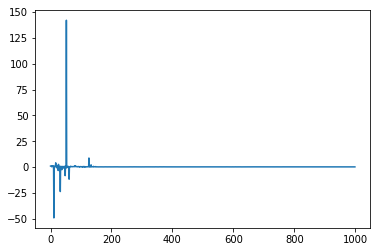

In [37]:
plt.plot(historyAnn.history.get('val_loss'))

In [38]:
print(modelAnn_best_loss, modelAnn_best_epoch)

45.637596130371094 12


## Training Models - 3. Gradient Boosting Trees 

In [39]:
modelXgb = XGBRegressor(max_depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=random_seed,)

modelXgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=10,)

[0]	validation_0-rmse:3.57892
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.18874
[20]	validation_0-rmse:1.39163
[30]	validation_0-rmse:0.960123
[40]	validation_0-rmse:0.75091
[50]	validation_0-rmse:0.661845
[60]	validation_0-rmse:0.630652
[70]	validation_0-rmse:0.621688
[80]	validation_0-rmse:0.617711
[90]	validation_0-rmse:0.618147
[100]	validation_0-rmse:0.61885
[110]	validation_0-rmse:0.61996
[120]	validation_0-rmse:0.620213
[130]	validation_0-rmse:0.620732
Stopping. Best iteration:
[84]	validation_0-rmse:0.61745



XGBRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, n_jobs=-1,
             seed=123, subsample=0.7, verbosity=0)

# Score and evaluate all models

In [40]:
# predictions on test set
y_pred_Ann_test = modelAnn.predict(X_test)
y_pred_Tabnet_test = modelTabnet.predict(X_test)
y_pred_Xgb_test = modelXgb.predict(X_test).reshape(-1,1)

# predictions on train/val set
X_trainval = np.append(X_train, X_valid, axis=0)
y_trainval = np.append(y_train, y_valid, axis=0)

y_pred_Ann_trainval = modelAnn.predict(X_trainval)
y_pred_Tabnet_trainval = modelTabnet.predict(X_trainval)
y_pred_Xgb_trainval = modelXgb.predict(X_trainval).reshape(-1,1)


In [41]:
def eval_performance_allmetrics(y_pred, y_true):
# list of eval metrics ['mae', 'mse', 'rmse', r_squared, CPC]
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
    mse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=True)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False)
    r_squared = r2_score(y_pred=y_pred, y_true=y_true)
    cpc = 2 * np.sum(np.minimum((y_true), y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    return [mae, mse, rmse, r_squared, cpc]

In [42]:
performance_metrics_name = ['mae', 'mse', 'rmse', 'r_squared', 'CPC']

performance_Ann_test = eval_performance_allmetrics(y_pred_Ann_test, y_test)
performance_Tabnet_test = eval_performance_allmetrics(y_pred_Tabnet_test, y_test)
performance_Xgb_test = eval_performance_allmetrics(y_pred_Xgb_test, y_test)

performance_Ann_trainval = eval_performance_allmetrics(y_pred_Ann_trainval, y_trainval)
performance_Tabnet_trainval = eval_performance_allmetrics(y_pred_Tabnet_trainval, y_trainval)
performance_Xgb_trainval = eval_performance_allmetrics(y_pred_Xgb_trainval, y_trainval)

In [43]:
print(performance_Ann_test, performance_Tabnet_test, performance_Xgb_test)

[1.3708156, 2.751293, 1.6587021, 0.6055620520580021, 0.8268905779183714] [0.57244146, 1.0504673, 1.0249231, 0.849400199147312, 0.9152644765927751] [0.39988044, 0.327792, 0.5725312, 0.9530062457403933, 0.9401026120110626]


In [44]:
# performance 
df_metric = pd.DataFrame(np.transpose([performance_metrics_name, performance_Ann_test, performance_Tabnet_test, performance_Xgb_test, performance_Ann_trainval, performance_Tabnet_trainval, performance_Xgb_trainval]), columns=["Metrics", "ANN_on_test", "TabNet_on_test", "XGB_on_test", "ANN_on_trainval", "TabNet_on_trainval", "XGB_on_trainval"])

In [45]:
for col in df_metric:
    if col != "Metrics":
        df_metric[col] = df_metric[col].astype("float").map('{:,.4f}'.format)
    
df_metric

,Metrics,ANN_on_test,TabNet_on_test,XGB_on_test,ANN_on_trainval,TabNet_on_trainval,XGB_on_trainval
0,mae,1.3708,0.5724,0.3999,1.3316,0.4580,0.2989
1,mse,2.7513,1.0505,0.3278,2.4653,0.6779,0.1889
2,rmse,1.6587,1.0249,0.5725,1.5701,0.8234,0.4346
3,r_squared,0.6056,0.8494,0.9530,0.6312,0.8986,0.9717
4,CPC,0.8269,0.9153,0.9401,0.8215,0.9269,0.9522


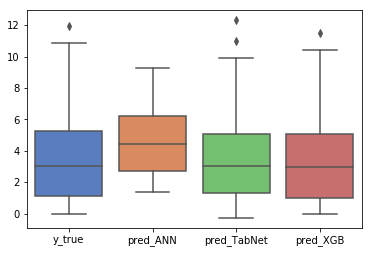

In [46]:
# Range of ground truth versus individual model predicted - BoxPlot
df_pred_test = pd.DataFrame(np.transpose([y_test.flatten(), y_pred_Ann_test.flatten(), y_pred_Tabnet_test.flatten(), y_pred_Xgb_test.flatten()]), columns=["y_true", "pred_ANN", "pred_TabNet", "pred_XGB"])
sns.boxplot(data= df_pred_test, palette="muted")
plt.savefig('./exhibits/variant_lag/prediction_comparison.png')

# Model Intepretations

## Shapley result intepretation 

### Calculations for three fitted models 

In [47]:
shap.initjs()

def modelAnn_predictor(X):
    return modelAnn.predict(X).flatten()

def modelTabnet_predictor(X):
    return modelTabnet.predict(X).flatten()

def modelXgb_predictor(X):
    return modelXgb.predict(X).flatten()

# using a fixed subsample to approximate the whole test set
fixed_subsample=shap.sample(X_test,1000)

explainerANN = shap.KernelExplainer(modelAnn_predictor, shap.sample(X_trainval,50))
shap_valuesANN = explainerANN.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerTabnet = shap.KernelExplainer(modelTabnet_predictor, shap.sample(X_trainval,50))
shap_valuesTabnet = explainerTabnet.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerXgb = shap.KernelExplainer(modelXgb_predictor, shap.sample(X_trainval,50))
shap_valuesXgb = explainerXgb.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

# In theory code below also works, but it runs extremely long
# explainer = shap.KernelExplainer(f, X_trainval)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [48]:
shap_values = shap_valuesTabnet

### Using Shap to create overview summary of relationship between features and target

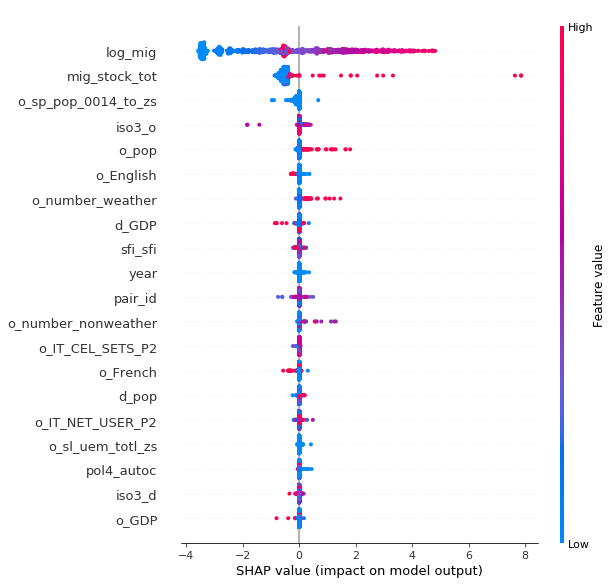

In [49]:
shap.summary_plot(shap_values, fixed_subsample, features, show=False)

### Using Shap to create a variable importance graph

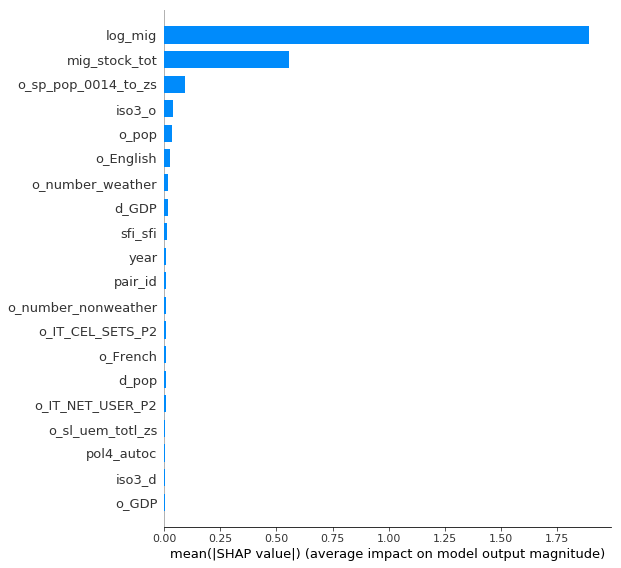

In [50]:
shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)

### Using Shap to create a PDP-like insights

SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The plots show variation in dot color corresponding to presence of suggested interactions.

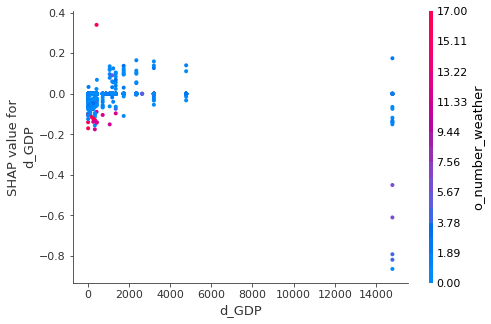

In [51]:
shap.dependence_plot("d_GDP", shap_values, fixed_subsample, features, show=False)

### Using Shap additive force layout

In [52]:
# shap.force_plot(explainer.expected_value, shap_values, features)


### Saving SHAP Exhibits

In [53]:
def generate_shap_Exhibits(shap_values, model, dataset):
    shap.summary_plot(shap_values, fixed_subsample, features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/variant_lag/{}_shap_overview.png'.format(model), bbox_inches='tight')
    plt.close()

    shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/variant_lag/{}_varimp.png'.format(model), bbox_inches='tight')
    plt.close()

    for f in features:
        shap.dependence_plot(f, shap_values, fixed_subsample, features, show=False)
        plt.title('{} {} '.format(model, dataset), fontsize=4)
        plt.savefig('./exhibits/variant_lag/{}_dp_{}.png'.format(model, f), bbox_inches='tight')
        plt.close()


In [54]:
generate_shap_Exhibits(shap_values=shap_valuesXgb, model="XGB", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesANN, model="ANN", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesTabnet, model="TabNet", dataset="on sampled Test set")




# Interpreting TabNet Results

TabNet [3] is an interpretable deep learning architecture from Google AI that ingests tabular data and leverages the layers that comprise its sequential attention mechanism, providing both decision-step and aggregate-feature importance masks.

In [55]:
explain_matrix, masks = modelTabnet.explain(X_test)


Feature importance masks from a TabNet model show the importance of each feature for the top N samples. Feature importance masks (Mask i indicates feature selection at ith step) showing the global instance-wise feature selection. Brighter colors show a higher value. 

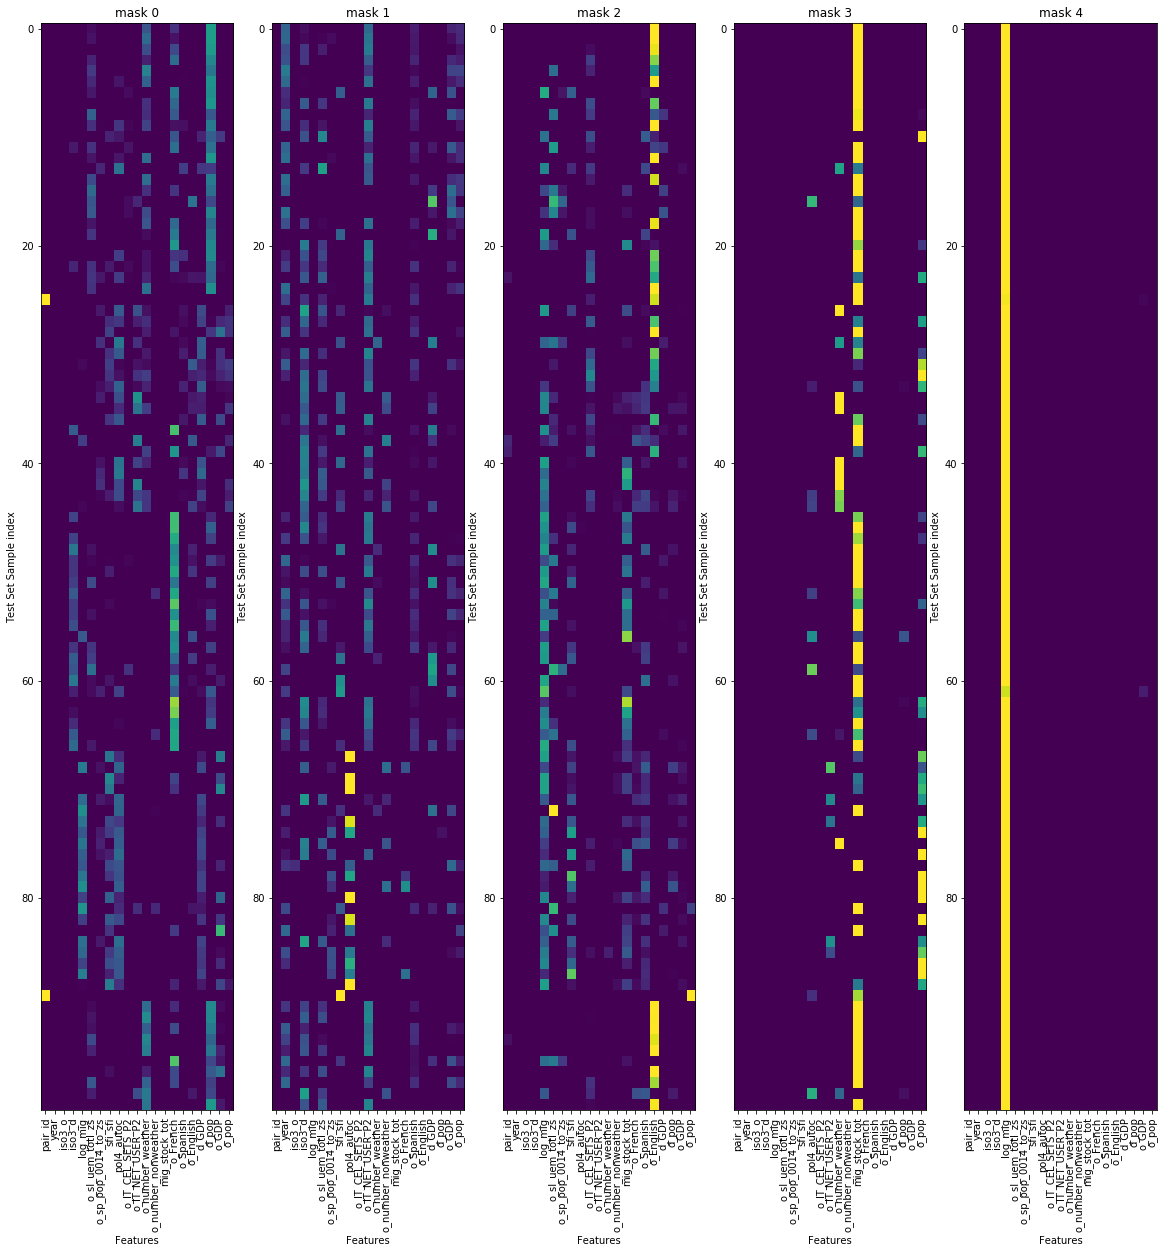

In [56]:
%matplotlib inline
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:100], aspect="auto")
    axs[i].set_title(f"mask {i}")
    axs[i].set_xlabel('Features')
    axs[i].set_ylabel('Test Set Sample index')
    axs[i].xaxis.set_ticks(np.arange(len(features)))
    axs[i].set_xticklabels(features, rotation='vertical')
plt.savefig('./exhibits/variant_lag/TabNet_intepretation.png')

## References ##


[1] N. Golenvaux, P. G. Alvarez, H. S. Kiossou and P. Schaus, "An LSTM approach to Predict Migration based on Google Trends" ArXiv, abs/2005.09902. Published 2020.

[2] M. H. Böhme, A. Gröger, and T. Stöhr, “Searching for a better life: Predicting international migration with online search keywords,” Journal of Development Economics, vol. 142, p. 102347, Jan. 2020, doi: 10.1016/j.jdeveco.2019.04.002.

[3] S. O. Arik, and T. Pfister, "TabNet: Attentive Interpretable Tabular Learning". 2019. arXiv preprint arXiv:1908.07442, 2019. URL: https://arxiv.org/pdf/1908.07442.pdf

[4] A. P. Masucci, J. Serras, A. Johansson, and M. Batty, “Gravity versus radiation models: On the importance of scale and heterogeneity in commuting flows,” Physical Review E, vol. 88, no. 2, p. 022812, 2013.

[5] C. Robinson and B. Dilkina, “A machine learning approach to modeling human migration,” in Proceedings of the 1st ACM SIGCAS Conference on Computing and Sustainable Societies, 2018, pp. 1–8.

[6] F. A. Gers, J. Schmidhuber, and F. Cummins, “Learning to Forget: Continual Prediction with LSTM,” Neural Computation, vol. 12, no. 10, pp. 2451–2471, Oct. 2000, doi: 10.1162/089976600300015015.

[7] S. Hochreiter and J. Schmidhuber, “Long short-term memory,” Neural computation, vol. 9, no. 8, pp. 1735–1780, 1997.

[8] C. Molnar, “Interpretable Machine Learning - A Guide for Making Black Box Models Explainable,” https://christophm.github.io/interpretable-ml-book/index.html

[9] International Migration Institute,”Determinants of International Migration (DEMIG) - POLICY data”. 2021.